In [2]:
import os
import PIL
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model

In [4]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
from tensorflow.keras.regularizers import l2
#from keras.preprocessing import image
num_classes = 5

IMAGE_SIZE = [511, 511]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)                  # we can add a new fully connected layer but it will increase the execution time.
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 511, 511, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 511, 511, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 511, 511, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 255, 255, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 255, 255, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 255, 255, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 127, 127, 128)     0     

In [6]:
train_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/grapeLeavesDataset511/train'
valid_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/grapeLeavesDataset511/valid'
test_dir = '/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/grapeLeavesDataset511/test'

num_classes = 5

In [7]:
IMAGE_SIZE = [511, 511]

train_gen = ImageDataGenerator(
    rescale=1./255
    )
val_gen = ImageDataGenerator(
    rescale=1./255
    )  
test_gen = ImageDataGenerator(
    rescale=1./255
    )


train_set = train_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
val_set = val_gen.flow_from_directory(
    valid_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 4400 images belonging to 5 classes.
Found 450 images belonging to 5 classes.
Found 450 images belonging to 5 classes.


In [8]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
    metrics=['accuracy']
    )

In [8]:
VGG_model = model.fit(
     train_set,
     validation_data=val_set, 
     epochs=10,
     steps_per_epoch = len(train_set),
     validation_steps = len(val_set),)

Epoch 1/10


2023-11-27 20:27:43.798978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


275/275 [==============================] - 507s 2s/step - loss: 0.7448 - accuracy: 0.7370 - val_loss: 0.4996 - val_accuracy: 0.8756
Epoch 2/10
275/275 [==============================] - 733s 3s/step - loss: 0.1672 - accuracy: 0.9602 - val_loss: 0.3540 - val_accuracy: 0.8511
Epoch 3/10
275/275 [==============================] - 741s 3s/step - loss: 0.0772 - accuracy: 0.9884 - val_loss: 0.3051 - val_accuracy: 0.8800
Epoch 4/10
275/275 [==============================] - 736s 3s/step - loss: 0.0499 - accuracy: 0.9950 - val_loss: 0.3396 - val_accuracy: 0.8756
Epoch 5/10
275/275 [==============================] - 596s 2s/step - loss: 0.0381 - accuracy: 0.9955 - val_loss: 0.3228 - val_accuracy: 0.8844
Epoch 6/10
275/275 [==============================] - 467s 2s/step - loss: 0.0223 - accuracy: 0.9998 - val_loss: 0.2969 - val_accuracy: 0.8756
Epoch 7/10
275/275 [==============================] - 532s 2s/step - loss: 0.0198 - accuracy: 0.9980 - val_loss: 0.2986 - val_accuracy: 0.8800
Epoch 8/10

In [9]:
VGG_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [10]:
acc = VGG_model.history['accuracy']
val_acc = VGG_model.history['val_accuracy']

loss = VGG_model.history['loss']
val_loss = VGG_model.history['val_loss']

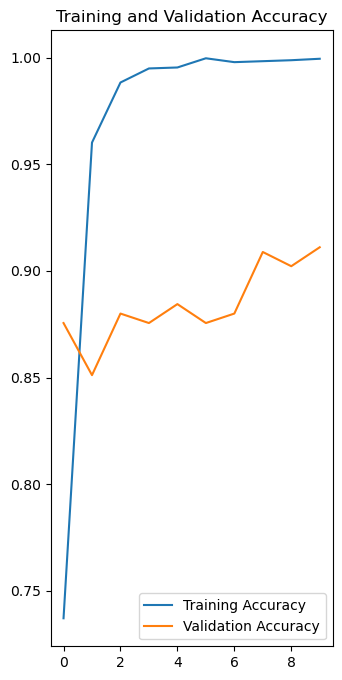

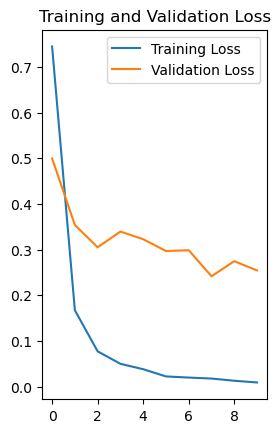

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
predictions = model.predict(test_set)

29/29 [==============================] - 38s 1s/step


In [13]:
y_pred = np.argmax(predictions, axis=-1)

In [14]:
test_set.class_indices

{'Ak': 0, 'Ala_Idris': 1, 'Buzgulu': 2, 'Dimnit': 3, 'Nazli': 4}

In [15]:
scores = model.evaluate(test_set, batch_size=16, verbose=2)

29/29 - 40s - loss: 0.5421 - accuracy: 0.8378 - 40s/epoch - 1s/step
